<a href="https://colab.research.google.com/github/YugantGotmare/Brain_tumor-detection/blob/master/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
import keras

In [ ]:
data_dir = '/content/gdrive/MyDrive/brain_tumor' 

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/brain_tumor')

Found 1435 files belonging to 2 classes.


In [ ]:
len(data)

45

In [ ]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [ ]:
train_size

32

In [ ]:
val_size

10

In [ ]:
test_size

4

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_df = train.map(process)
validation_df = val.map(process)

## Normal CNN Model

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))   # 16 fillter it scan through the image give or extrat revelant information inside the image
model.add(MaxPooling2D())                                                     # relu convert negative value to zero and positive value remain unchange
                                                                              # Maxpooling give the maximum value
 
model.add(Conv2D(36, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Dropout(rate=0.1))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 125, 125, 36)      5220      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 36)       0         
 2D)                                                             
                                                                 
 conv2d_100 (Conv2D)         (None, 60, 60, 64)        20800     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)      

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1, mode='auto')

check = ModelCheckpoint(monitor='val_accuracy',filepath="./bestmodel.h5", save_best_only=True, verbose=1, mode='auto')

call = [early,check]

In [ ]:
history = model.fit(train_df,epochs=20,validation_data=validation_df,callbacks=call)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.8262
Epoch 1: val_accuracy improved from -inf to 0.87187, saving model to ./bestmodel.h5
32/32 [==============================] - 8s 206ms/step - loss: 0.4324 - accuracy: 0.8262 - val_loss: 0.2999 - val_accuracy: 0.8719
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.3736 - accuracy: 0.8418
Epoch 2: val_accuracy did not improve from 0.87187
32/32 [==============================] - 7s 197ms/step - loss: 0.3736 - accuracy: 0.8418 - val_loss: 0.3323 - val_accuracy: 0.8719
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.8594
Epoch 3: val_accuracy did not improve from 0.87187
32/32 [==============================] - 7s 195ms/step - loss: 0.3030 - accuracy: 0.8594 - val_loss: 0.3224 - val_accuracy: 0.8438
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8672
Epoch 4: val_accuracy did not improve from 0.

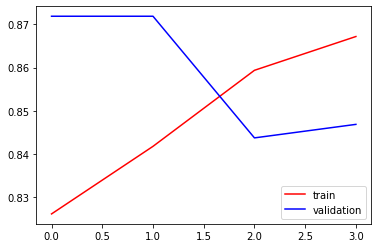

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

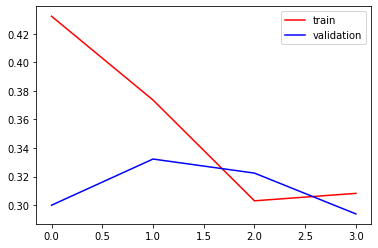

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
accuracy_of_normal_model = model.evaluate(test)[1] * 100
print("Accuracy:",accuracy_of_normal_model)

3/3 [==============================] - 3s 34ms/step - loss: 14.2006 - accuracy: 0.8571
Accuracy: 85.71428656578064


# VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

In [ ]:
vgg = VGG16(input_shape=[256,256] + [3], weights='imagenet', include_top=False)

In [ ]:
vgg.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_5')>

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
model_vgg = Model(inputs=vgg.input, outputs=prediction)
model_vgg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
model_vgg.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
vgg_history = model_vgg.fit(train_df,epochs=20,validation_data=validation_df,callbacks=call)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.8125
Epoch 1: val_accuracy did not improve from 0.87187
32/32 [==============================] - 13s 363ms/step - loss: 0.6630 - accuracy: 0.8125 - val_loss: 0.3649 - val_accuracy: 0.8469
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.8799
Epoch 2: val_accuracy did not improve from 0.87187
32/32 [==============================] - 12s 364ms/step - loss: 0.2810 - accuracy: 0.8799 - val_loss: 0.4080 - val_accuracy: 0.8438
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.8984
Epoch 3: val_accuracy did not improve from 0.87187
32/32 [==============================] - 12s 364ms/step - loss: 0.2460 - accuracy: 0.8984 - val_loss: 0.3136 - val_accuracy: 0.8687
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9092
Epoch 4: val_accuracy did not improve from 0.87187
32/32 [=================

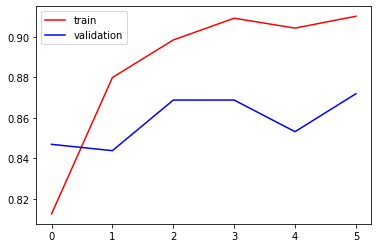

In [ ]:
plt.plot(vgg_history.history['accuracy'],color='red',label='train')
plt.plot(vgg_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

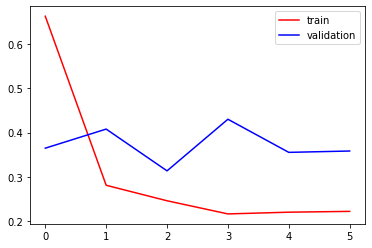

In [ ]:
plt.plot(vgg_history.history['loss'],color='red',label='train')
plt.plot(vgg_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
accuracy_of_vgg_model = model_vgg.evaluate(test)[1] * 100
print("Accuracy:",accuracy_of_vgg_model)

3/3 [==============================] - 5s 198ms/step - loss: 4.5802 - accuracy: 0.9011
Accuracy: 90.1098906993866


# ResNet50 

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
# resnet_model = Sequential()

# pretrained_model= tf.keras.applications.ResNet50(include_top=False,
#                    input_shape=(256,256,3),
#                    pooling='avg',classes=2,
#                    weights='imagenet')
resnet = ResNet50(
    input_shape = [256,256] + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   # 
)

In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
x = Flatten() (resnet.output)
prediction = Dense(2, activation = 'softmax')(x)
resnet_model = Model(inputs = resnet.input, outputs = prediction)
resnet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
resnet_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_df, validation_data=validation_df, epochs=20, callbacks=call)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 4.0218 - accuracy: 0.7695
Epoch 1: val_accuracy did not improve from 0.87187
32/32 [==============================] - 13s 290ms/step - loss: 4.0218 - accuracy: 0.7695 - val_loss: 2.9797 - val_accuracy: 0.8219
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 1.0941 - accuracy: 0.8340
Epoch 2: val_accuracy did not improve from 0.87187
32/32 [==============================] - 9s 262ms/step - loss: 1.0941 - accuracy: 0.8340 - val_loss: 0.4541 - val_accuracy: 0.8719
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8564
Epoch 3: val_accuracy did not improve from 0.87187
32/32 [==============================] - 9s 264ms/step - loss: 0.3977 - accuracy: 0.8564 - val_loss: 0.5130 - val_accuracy: 0.8625
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.9275 - accuracy: 0.8096
Epoch 4: val_accuracy did not improve from 0.87187
32/32 [===================

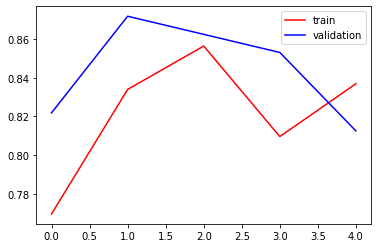

In [ ]:
plt.plot(resnet_history.history['accuracy'],color='red',label='train')
plt.plot(resnet_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

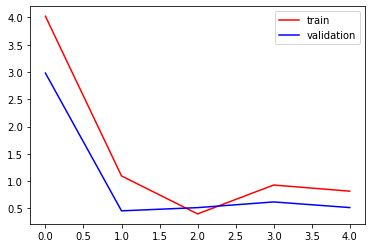

In [ ]:
plt.plot(resnet_history.history['loss'],color='red',label='train')
plt.plot(resnet_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
accuracy_of_resnet_model = resnet_model.evaluate(test)[1] * 100
print("Accuracy:",accuracy_of_resnet_model)

3/3 [==============================] - 3s 125ms/step - loss: 7.5166 - accuracy: 0.8681
Accuracy: 86.81318759918213


# Inception V3


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
Inception = InceptionV3(input_shape = (256, 256, 3),
                                include_top = False, 
                                weights = 'imagenet')

In [ ]:
Inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 127, 127, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_102[0][0]']             
 ormalization)                  )                                                      

In [ ]:
for layer in Inception.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(Inception.output)
prediction = Dense(2, activation='sigmoid')(x)           
Inception_model = Model(inputs = Inception.input, outputs = prediction)
Inception_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 127, 127, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_102[0][0]']             
 ormalization)                  )                                                           

In [ ]:
Inception_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
Inception_history = Inception_model.fit(train_df, validation_data=validation_df, epochs=20, callbacks=call)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 5.9041 - accuracy: 0.7812
Epoch 1: val_accuracy did not improve from 0.87187
32/32 [==============================] - 13s 253ms/step - loss: 5.9041 - accuracy: 0.7812 - val_loss: 1.7992 - val_accuracy: 0.8625
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.8662
Epoch 2: val_accuracy improved from 0.87187 to 0.87500, saving model to ./bestmodel.h5
32/32 [==============================] - 8s 236ms/step - loss: 1.0796 - accuracy: 0.8662 - val_loss: 0.9549 - val_accuracy: 0.8750
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.8965
Epoch 3: val_accuracy did not improve from 0.87500
32/32 [==============================] - 9s 267ms/step - loss: 0.7497 - accuracy: 0.8965 - val_loss: 1.5997 - val_accuracy: 0.8625
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.9082
Epoch 4: val_accuracy did not improve fro

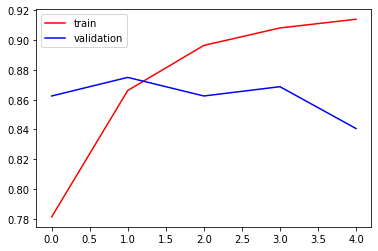

In [ ]:
plt.plot(Inception_history.history['accuracy'],color='red',label='train')
plt.plot(Inception_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

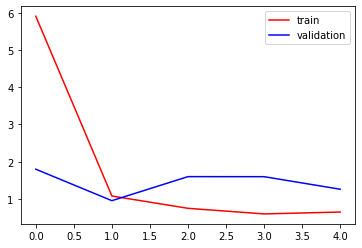

In [ ]:
plt.plot(Inception_history.history['loss'],color='red',label='train')
plt.plot(Inception_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
accuracy_of_Inception_model = Inception_model.evaluate(test)[1] * 100
print("Accuracy:",accuracy_of_Inception_model)

3/3 [==============================] - 3s 109ms/step - loss: 140.8236 - accuracy: 0.1538
Accuracy: 15.384615957736969


# MobileNet

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

In [ ]:
mobile = MobileNet(weights='imagenet',
                     include_top=False)

In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                         

In [ ]:
for layer in mobile.layers:
  layer.trainable = False

In [ ]:
from keras.layers import Dense,GlobalAveragePooling2D

x = GlobalAveragePooling2D()(mobile.output)
prediction=Dense(2,activation='softmax')(x)
mobile_model=Model(inputs=mobile.input,outputs=prediction)
mobile_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

In [ ]:
mobile_model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
mobile_history = mobile_model.fit(train_df, validation_data=validation_df, epochs=20, callbacks=call)

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8379
Epoch 1: val_accuracy did not improve from 0.87500
32/32 [==============================] - 9s 212ms/step - loss: 0.4291 - accuracy: 0.8379 - val_loss: 0.3408 - val_accuracy: 0.8531
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.8477
Epoch 2: val_accuracy did not improve from 0.87500
32/32 [==============================] - 7s 198ms/step - loss: 0.3405 - accuracy: 0.8477 - val_loss: 0.3720 - val_accuracy: 0.8281
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.3129 - accuracy: 0.8682
Epoch 3: val_accuracy did not improve from 0.87500
32/32 [==============================] - 7s 198ms/step - loss: 0.3129 - accuracy: 0.8682 - val_loss: 0.3333 - val_accuracy: 0.8375
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.8730
Epoch 4: val_accuracy did not improve from 0.87500
32/32 [====================

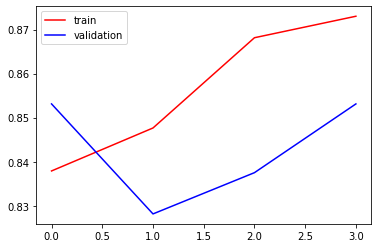

In [ ]:
plt.plot(mobile_history.history['accuracy'],color='red',label='train')
plt.plot(mobile_history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

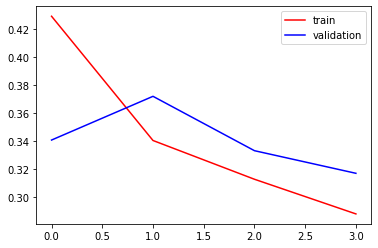

In [ ]:
plt.plot(mobile_history.history['loss'],color='red',label='train')
plt.plot(mobile_history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
accuracy_of_mobilenet_model = mobile_model.evaluate(test)[1] * 100
print("Accuracy:",accuracy_of_mobilenet_model)

3/3 [==============================] - 3s 65ms/step - loss: 0.5184 - accuracy: 0.8132
Accuracy: 81.31868243217468


In [ ]:
print("Accuracy of Normal Model: ", accuracy_of_normal_model,"%")
print("Accuracy of VGG Model: ", accuracy_of_vgg_model,"%")
print("Accuracy of ResNet Model: ", accuracy_of_resnet_model,"%")
print("Accuracy of Inception Model: ", accuracy_of_Inception_model,"%")
print("Accuracy of MobileNet Model: ", accuracy_of_mobilenet_model,"%")

Accuracy of Normal Model:  85.71428656578064 %
Accuracy of VGG Model:  90.1098906993866 %
Accuracy of ResNet Model:  86.81318759918213 %
Accuracy of Inception Model:  15.384615957736969 %
Accuracy of MobileNet Model:  81.31868243217468 %
